# Reasoning behind data cleaning

## Plain English Summary

This notebook explains the decisions made when cleaning SSNAP extract v2.

## Aims

* Explain decisions related to variables that were included in the clean dataset
* Explain why some variables from the SSNAP data were not included in the clean dataset

## Observations

tbc

## Set up

In [1]:
# Import packages and functions
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from dataclasses import dataclass

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

# Set the maximum number of columns and rows to 150
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)


# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    raw_path = './../data'
    raw_filename = 'SAMueL ssnap extract v2.csv'
    notebook = '01'


paths = Paths()

In [2]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path, paths.data_filename))
raw_data = pd.read_csv(os.path.join(paths.raw_path, paths.raw_filename),
                       low_memory=False)

In [3]:
def compare_raw_clean(raw_data, clean_data):
    '''
    Merges the raw and clean data using patient ID
    Then presents counts for the remaining columns when ID is dropped
    '''
    compare = pd.merge(left=clean_data, left_on='id',
                       right=raw_data, right_on='PatientId')
    differences = (compare
                   .drop(columns=['id', 'PatientId'], axis=1)
                   .value_counts(dropna=False)
                   .reset_index(name='count'))
    return (differences.sort_values(differences.columns[0]))


def mark_missing(df):
    '''
    Identifies NaN then marks each value as missing data or having data
    '''
    df_missing = (pd.DataFrame(df)
                  .isnull()
                  .apply(lambda x: x.map({True: 'Missing data',
                                          False: 'Have data'})))
    return (df_missing)

## Included variables

### Overview of dataset

In [4]:
# Show shape of the data
data.shape

(358993, 70)

In [5]:
# List all columns and show their data types and proportion of completed data
data_type_complete = pd.DataFrame(
    {'Data type': data.dtypes,
     'Proportion complete': data.count() / data.shape[0]})

# Show all columns
data_type_complete

,Data type,Proportion complete
id,int64,1.000000
stroke_team,object,1.000000
age,float64,1.000000
male,int64,1.000000
infarction,float64,1.000000
onset_to_arrival_time,float64,0.670144
onset_known,int64,1.000000
precise_onset_known,int64,1.000000
onset_during_sleep,int64,1.000000
arrive_by_ambulance,int64,1.000000


### ID

The patient ID from the SSNAP dataset is included, as this provides a consistent identifier between the raw data and different/cleaned versions of the data.

<mark>Changed.</mark> Was originally based on row number


### Stroke team

No comment - as in SSNAP dataset.

### Age

The SSNAP data provides age and arrival time as categories. These were converted to numerical variables based on the middle value in each category. We do not have data on what the average age or arrival time was for each category, so this is an assumption. There is a chance that, for example, for ages 90 or over, the average age is actually lower than 92.5. However, in lieu of that information, this is considered a reasonable guess.

In [6]:
# Convert raw age to single column
raw_ages = pd.DataFrame(raw_data['PatientId'])
raw_ages['raw_age'] = raw_data[[
    col for col in raw_data if col.startswith('Age')]].idxmax(1)

# Merge with clean and present difference
compare_raw_clean(raw_ages, data[['id', 'age']])

,age,raw_age,count
10,37.5,AgeUnder40,6110
11,42.5,Age40to44,5072
9,47.5,Age45to49,9314
8,52.5,Age50to54,15839
7,57.5,Age55to59,21285
6,62.5,Age60to64,26881
5,67.5,Age65to69,33609
3,72.5,Age70to74,45959
1,77.5,Age75to79,52542
0,82.5,Age80to84,56912


### Gender

No comment - as in SSNAP dataset.

### Stroke type

It is vital that we understand stroke type, so patients were missing stroke type (missing due to having not received a scan) were completely removed from the clean dataset.

<mark>Changed.</mark> They were previously marked as having not had an infarction (=0)

In [7]:
# Show relationship between missing stoke type and missing arrival to scan time
(mark_missing(raw_data[['S2StrokeType', 'ArrivaltoBrainImagingMinutes']])
 .value_counts()
 .reset_index(name='count'))

,S2StrokeType,ArrivaltoBrainImagingMinutes,count
0,Have data,Have data,358993
1,Missing data,Missing data,1388


### Onset time

* Onset to arrival time
* Onset known
* Precise onset known
* Onset during sleep

<mark>Consider.</mark> For all of these, should they be dropped from the dataset entirely? Is it essential that we known their onset to arrival time, or can other information be useful without that? *Note*: This would be alot of people due to "unknown onset time" - but consider the thrombolysis use below?

**Zero onset to arrival:** There are several individuals who have 0 minutes between onset and arrival, and it does not appear to be due to having not arrived by ambulance. Hence, it is felt that we do not trust these times and replaced them as missing.

<mark>Changed.</mark> Previously included.

In [8]:
# Count with 0 onset to arrival time in raw data, by whether they
# arrived by ambulance
print('Frequency of onset to arrival = 0 in raw data...')
display(raw_data.groupby('S1ArriveByAmbulance')['OnsettoArrivalMinutes']
        .apply(lambda x: (x == 0).sum())
        .reset_index(name='Count where onset to arrival = 0'))

# Demonstrating there are no times equal to 0 in clean data
print('Frequency of onset to arrival = 0 in clean data...')
display((data['onset_to_arrival_time'] == 0).value_counts())

Frequency of onset to arrival = 0 in raw data...


,S1ArriveByAmbulance,Count where onset to arrival = 0
0,N,11
1,Y,48


Frequency of onset to arrival = 0 in clean data...


False    358993
Name: onset_to_arrival_time, dtype: int64

**Unknown onset time:** There are many cases where onset time is marked as "unknown" but an onset to arrival time was provided for every person in the dataset. In these cases, onset to arrival time has been set as missing in the clean data. Not removed entirely from the data, as this represents a very large proportion of people in the dataset, and could have valuable information like for outcomes.

<mark>Changed.</mark> Previously included.

In [9]:
print('Number of people with onset time not known in raw data')
display((raw_data['S1OnsetTimeType'] == 'NK').value_counts())

print('Onset to arrival time when onset time not known in clean data')
data.loc[data['onset_known'] == 0,
         'onset_to_arrival_time'].value_counts(dropna=False)

Number of people with onset time not known in raw data


False    241138
True     119243
Name: S1OnsetTimeType, dtype: int64

Onset to arrival time when onset time not known in clean data


NaN    118416
Name: onset_to_arrival_time, dtype: int64

These typically appear to be the difference between midnight and the arrival time (e.g. of people with an onset to arrival of 1 to 2 hours, nearly all of them have an arrival time of 0000 to 3000).

In [10]:
# Extract people with onset time not known
unknown_time = raw_data.loc[
    raw_data['S1OnsetTimeType'] == 'NK',
    ['OnsettoArrivalMinutes', 'FirstArrivalTime', 'S2Thrombolysis']]

# Convert onset to arrival to hours and round down
unknown_time['onset_to_arrival_hours'] = (
    np.floor(unknown_time['OnsettoArrivalMinutes']/60))

(unknown_time[['FirstArrivalTime', 'onset_to_arrival_hours']]
 .value_counts()
 .reset_index(name='count')
 .sort_values(by='onset_to_arrival_hours')
 .head(20))

,FirstArrivalTime,onset_to_arrival_hours,count
969,0900to1200,-12.0,1
1111,0600to0900,-1.0,1
656,1800to2100,0.0,2
781,0300to0600,0.0,2
859,2100to2400,0.0,1
743,1200to1500,0.0,2
474,0600to0900,0.0,5
68,0000to3000,0.0,343
678,1500to1800,0.0,2
613,0900to1200,0.0,3


Over 99% did not receive thrombolysis. Of those who received thrombolysis, the onset to arrival time was typically quite high and seems unusual (in the clean data, no-one has thrombolysis for an onset to arrival time greater than 12 hours).

In [11]:
unknown_time['S2Thrombolysis'].value_counts(dropna=False)

NB    118119
Y        580
N        544
Name: S2Thrombolysis, dtype: int64

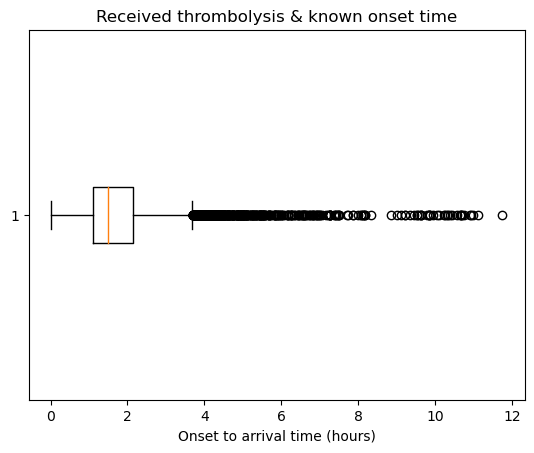

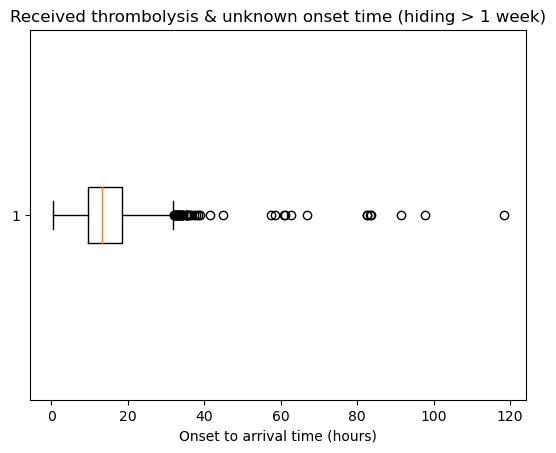

In [12]:
# Extract people who received thrombolysis
onset = raw_data.loc[
    raw_data['S2Thrombolysis'] == 'Y',
    ['S1OnsetTimeType', 'OnsettoArrivalMinutes']]

# Convert onset to arrival from minutes to hours
onset['onset_to_arrival_hours'] = onset['OnsettoArrivalMinutes']/60

# Create dataframes where onset time is known or not
onset_known = onset.loc[onset['S1OnsetTimeType'] != 'NK',
                        'onset_to_arrival_hours']
onset_unknown = onset.loc[((onset['S1OnsetTimeType'] == 'NK') &
                           (onset['onset_to_arrival_hours'] < 168)),
                          'onset_to_arrival_hours']

plt.boxplot(onset_known, vert=False)
plt.xlabel('Onset to arrival time (hours)')
plt.title('Received thrombolysis & known onset time')
plt.show()

plt.boxplot(onset_unknown, vert=False)
plt.xlabel('Onset to arrival time (hours)')
plt.title('Received thrombolysis & unknown onset time (hiding > 1 week)')
plt.show()

**Large onset to arrival time:** A large onset to arrival time is plausible, but some results are so large that they are considered to be invalid and likely errors in the data, or incredibly anomalous results.

<mark>To change.</mark> Being included. Suggested perhaps filter out over three days

In [13]:
# Years
# Convert time from minutes to years then present counts (rounded)
onset_arrival_years = data['onset_to_arrival_time']/525600
round(onset_arrival_years).value_counts().sort_index()

0.0      240485
1.0          71
2.0           2
3.0           7
8.0           1
10.0          1
15.0          2
16.0          4
17.0          1
18.0          1
76.0          1
118.0         1
Name: onset_to_arrival_time, dtype: int64

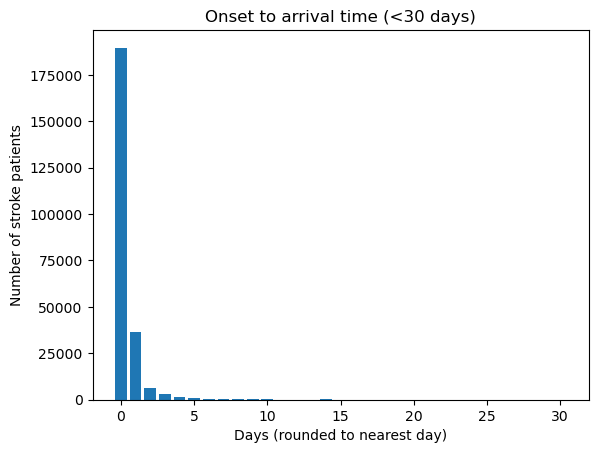

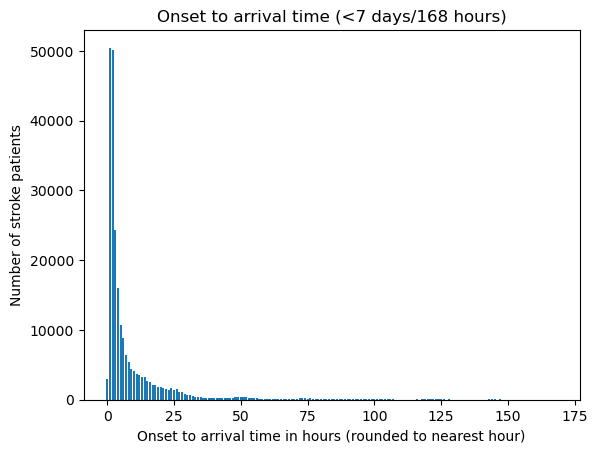

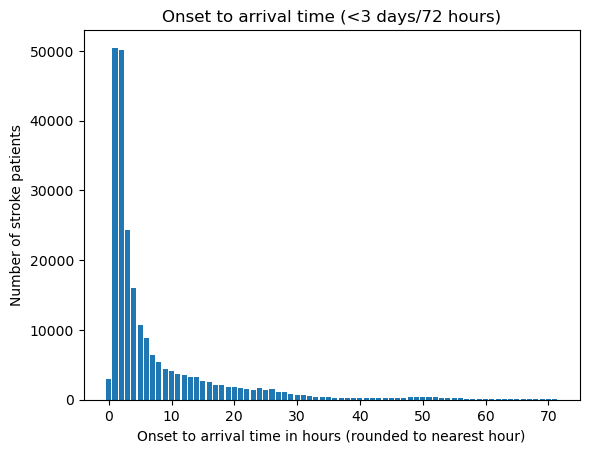

In [14]:
# Days
onset_arrival_days = data['onset_to_arrival_time']/1440
onset_arrival_days_count = (round(onset_arrival_days[onset_arrival_days < 30])
                            .value_counts()
                            .sort_index()
                            .reset_index(name='count'))
fig = plt.figure()
plt.bar(onset_arrival_days_count['index'], onset_arrival_days_count['count'])
plt.xlabel('Days (rounded to nearest day)')
plt.ylabel('Number of stroke patients')
plt.title('Onset to arrival time (<30 days)')
plt.show()

# Hours
onset_arrival_hours = data['onset_to_arrival_time']/60
onset_arrival_hours_count = (
    round(onset_arrival_hours[onset_arrival_hours < 168])
    .value_counts()
    .sort_index()
    .reset_index(name='count'))

plt.bar(onset_arrival_hours_count['index'],
        onset_arrival_hours_count['count'])
plt.xlabel('Onset to arrival time in hours (rounded to nearest hour)')
plt.ylabel('Number of stroke patients')
plt.title('Onset to arrival time (<7 days/168 hours)')
plt.show()

onset_arrival_hours_shorter = onset_arrival_hours_count[
    onset_arrival_hours_count['index'] < 72]
plt.bar(onset_arrival_hours_shorter['index'],
        onset_arrival_hours_shorter['count'])
plt.xlabel('Onset to arrival time in hours (rounded to nearest hour)')
plt.ylabel('Number of stroke patients')
plt.title('Onset to arrival time (<3 days/72 hours)')
plt.show()

### Ambulance times

In cases where any ambulance times are missing or inappropriate, all ambulance times are set as missing.

In [15]:
# Extract ambulance times
raw_amb_times = raw_data[[
    'CallConnectedtoArrivalMinutes',
    'ArrivalPatientLocationtoArrivalMinutes',
    'DeparturePatientLocationtoArrivalMinutes',
    'WheelsStoptoArrivalMinutes']]
clean_amb_times = data[[
    'call_to_ambulance_arrival_time',
    'ambulance_on_scene_time',
    'ambulance_travel_to_hospital_time',
    'ambulance_wait_time_at_hospital']]

**Missing times**

The clean dataset either requires all times to be complete or all to be missing.

<mark>Changed.</mark> Previously included.

In [16]:
# Presence of missing ambulance times in clean data
(clean_amb_times
 .isnull()
 .apply(lambda x: x.map({True: 'Missing time', False: 'Has time'}))
 .value_counts()
 .reset_index(name='count'))

,call_to_ambulance_arrival_time,ambulance_on_scene_time,ambulance_travel_to_hospital_time,ambulance_wait_time_at_hospital,count
0,Missing time,Missing time,Missing time,Missing time,272913
1,Has time,Has time,Has time,Has time,86080


In [17]:
# Missing ambulance times in raw data
(raw_amb_times
 .isnull()
 .apply(lambda x: x.map({True: 'Missing time', False: 'Has time'}))
 .value_counts()
 .reset_index(name='count'))

,CallConnectedtoArrivalMinutes,ArrivalPatientLocationtoArrivalMinutes,DeparturePatientLocationtoArrivalMinutes,WheelsStoptoArrivalMinutes,count
0,Missing time,Missing time,Missing time,Missing time,251882
1,Has time,Has time,Has time,Has time,92958
2,Has time,Has time,Has time,Missing time,15421
3,Has time,Has time,Missing time,Missing time,87
4,Has time,Missing time,Missing time,Has time,8
5,Has time,Missing time,Missing time,Missing time,7
6,Missing time,Has time,Has time,Has time,5
7,Missing time,Has time,Missing time,Missing time,5
8,Has time,Missing time,Has time,Has time,3
9,Missing time,Has time,Has time,Missing time,3


**Negative times**

We get negative times when:
* A time is greater than the subsequent time in the sequence (e.g. call_to_ambulance_arrival is ArrivalPatient - CallConnected, but will be negative if CallConnected is larger than ArrivalPatient)
* WheelsStoptoArrivalMinutes is positive (as calculated by 0 - WheelsStop)

The clean dataset contains no negative times.

<mark>Changed.</mark> Previously included.

In [18]:
(raw_data['CallConnectedtoArrivalMinutes'] >
 raw_data['ArrivalPatientLocationtoArrivalMinutes']).value_counts()

False    360309
True         72
dtype: int64

In [19]:
(raw_data['ArrivalPatientLocationtoArrivalMinutes'] >
 raw_data['DeparturePatientLocationtoArrivalMinutes']).value_counts()

False    360229
True        152
dtype: int64

In [20]:
(raw_data['DeparturePatientLocationtoArrivalMinutes'] >
 raw_data['WheelsStoptoArrivalMinutes']).value_counts()

False    360011
True        370
dtype: int64

In [21]:
(raw_data['WheelsStoptoArrivalMinutes'] > 0).value_counts()

False    354343
True       6038
Name: WheelsStoptoArrivalMinutes, dtype: int64

In [22]:
(clean_amb_times < 0).value_counts().reset_index(name='count')

,call_to_ambulance_arrival_time,ambulance_on_scene_time,ambulance_travel_to_hospital_time,ambulance_wait_time_at_hospital,count
0,False,False,False,False,358993


**Times equal to zero**

It is plausible that the wait time at the hospital might be 0 minutes. However, a time of 0 minutes is not plausible for:
* Call received to ambulance arrival
* Length of time that ambulance is on scene
* Travel time to hospital

Hence, in those cases, all times are set as NaN.

<mark>Changed.</mark> Previously included.

In [23]:
(raw_amb_times == 0).value_counts().reset_index(name='count')

,CallConnectedtoArrivalMinutes,ArrivalPatientLocationtoArrivalMinutes,DeparturePatientLocationtoArrivalMinutes,WheelsStoptoArrivalMinutes,count
0,False,False,False,False,349050
1,False,False,False,True,11158
2,False,False,True,False,118
3,False,False,True,True,19
4,False,True,False,False,19
5,True,False,False,False,17


In [24]:
(clean_amb_times == 0).value_counts().reset_index(name='count')

,call_to_ambulance_arrival_time,ambulance_on_scene_time,ambulance_travel_to_hospital_time,ambulance_wait_time_at_hospital,count
0,False,False,False,False,347866
1,False,False,False,True,11127


**Unreasonably large times**

Large call to ambulance times - suggested cut-off at 24. Although a time at 98 hours may be a valid and real time that happened, it is very anomalous and is not what we would reasonably expect to happen in future - doesn't reflect normal variation in system - and so is considered appropriate to set that time as missing. There is one very high time (120 years) that is also definietely anomalous.

<mark>To change.</mark> Where should we set the threshold? Do you cut off at 24 hours? Even if something like 98 hours could be a real time (and not an error), is it so anomalous and outside of normal variation in system, that wouldn't expect to happen again? Presuming you would drop the entire patient record if over threshold as thinking it is valid but anomalous? Or not?

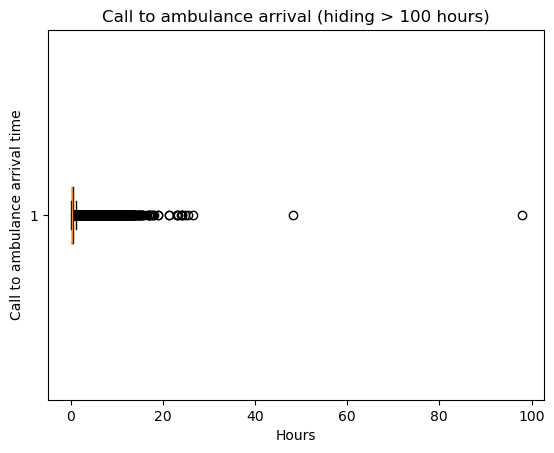

0.0     59443
1.0     21074
2.0      3242
3.0      1065
4.0       505
5.0       255
6.0       164
7.0        80
8.0        74
9.0        59
10.0       24
11.0       16
12.0       19
13.0       13
14.0       13
15.0        8
16.0        3
17.0        4
18.0        3
19.0        2
21.0        2
23.0        3
24.0        3
25.0        2
27.0        1
48.0        1
98.0        1
Name: call_to_ambulance_arrival_time, dtype: int64

In [25]:
# Convert time from minutes to hours
call_amb_hours = data['call_to_ambulance_arrival_time']/60

# Drop NA and drop really high value (1061774)
call_amb_hours_filter = call_amb_hours[call_amb_hours < 100].dropna()

# fig, ax = plt.subplots()
# ax.violinplot(call_amb_hours_filter, vert=False)
plt.boxplot(call_amb_hours_filter, vert=0)
plt.xlabel('Hours')
plt.ylabel('Call to ambulance arrival time')
plt.title('Call to ambulance arrival (hiding > 100 hours)')
plt.show()

round(call_amb_hours_filter).value_counts().sort_index()

**Times when didn't arrive by ambulance**

There are some individuals who have ambulance times yet are marked as having not arrived by ambulance. As we are therefore not certain that these are true times - for example, may have arrived by ambulance for a reason other than stroke and then had stroke later in hospital, but times have been accidentally added. Hence, times have been marked as NaN for these individuals.

<mark>Changed.</mark> Previously included.

In [26]:
# Number of times this is the case in the raw data
times_but_no_amb = (
    raw_data['S1ArriveByAmbulance'] == 'N') & (
        (raw_data['CallConnectedtoArrivalMinutes'].notnull()) |
        (raw_data['ArrivalPatientLocationtoArrivalMinutes'].notnull()) |
        (raw_data['DeparturePatientLocationtoArrivalMinutes'].notnull()) |
        (raw_data['WheelsStoptoArrivalMinutes'].notnull()))
times_but_no_amb.value_counts()

False    360372
True          9
dtype: int64

In [27]:
# Demonstrating these are removed from the clean data
clean_times_but_no_amb = (
    data['arrive_by_ambulance'] == 0) & (
        (data['call_to_ambulance_arrival_time'].notnull()) |
        (data['ambulance_on_scene_time'].notnull()) |
        (data['ambulance_travel_to_hospital_time'].notnull()) |
        (data['ambulance_wait_time_at_hospital'].notnull()))
clean_times_but_no_amb.value_counts()

False    358993
dtype: int64

### Day, month, year and time of arrival

No comment for day, month and year (just pulled from dataset).

For time of arrival, to convert from a categorical to numeric variable, we set arrival time to the start of each bracket. It is not a concern that this is different to age (where set to middle of the bracket), as the meaningful information for arrival time is the difference between each time (i.e. 3 units), which would be the same regardless of whether the start, middle or end of the bracket was used. The start was chosen as this was felt easier to understand than a half time, and as this is consistent with SAMueL1.

<mark>No change</mark> (beyond correction of final time)

In [28]:
# Extract relevant columns and merge
compare_time = pd.merge(
    left=data[['id', 'arrival_time_3_hour_period']], left_on='id',
    right=raw_data[['PatientId', 'FirstArrivalTime']], right_on='PatientId')

# Table illustrating change from categorical to numerical variable
(compare_time
 .drop(['PatientId', 'id'], axis=1)
 .value_counts(dropna=False)
 .reset_index(name='count')
 .sort_values(by='arrival_time_3_hour_period'))

,arrival_time_3_hour_period,FirstArrivalTime,count
6,0,0000to3000,15628
7,3,0300to0600,11481
5,6,0600to0900,24980
0,9,0900to1200,81705
1,12,1200to1500,78339
2,15,1500to1800,64213
3,18,1800to2100,50236
4,21,2100to2400,32411


### Scan, thrombolysis and thrombectomy

**Scan to thrombolysis time.** A scan to thrombolysis time of 0 is considered relatively plausible (that it could be very quick) and could be part of noise of data but not invalid results, so these have not been removed from the clean data.

<mark>No change</mark>

In [29]:
(data['scan_to_thrombolysis_time'] == 0).value_counts()

False    358702
True        291
Name: scan_to_thrombolysis_time, dtype: int64

**Thrombolysis.** No comment - Y (yes) to 1, and N or NB (no or no but) to 0.

**Thrombectomy.** If ArrivaltoArterialPunctureMinutes is NaN, we conclude they did not have a thrombectomy. Is there a possibility that this could be missing for anyone who did have a thrombectomy? No, the SSNAP team suggested that this is how we identify people who have had a thrombectomy, and that everyone who had one should have a time.

<mark>No change</mark>

In [30]:
# Show where raw data had or was missing data, then compare with clean data
raw_thrombectomy = mark_missing(raw_data['ArrivaltoArterialPunctureMinutes'])
raw_thrombectomy['PatientId'] = raw_data['PatientId']
compare_raw_clean(raw_thrombectomy,
                  data[['id', 'thrombectomy']])

,thrombectomy,ArrivaltoArterialPunctureMinutes,count
0,0,Missing data,354650
1,1,Have data,4343


### Comorbidities

**Diagnoses.** New atrial fibrillation diagnosis is missing data (should be complete for all cases where AtrialFibrillation = N), but still included in cleaned dataset for some descriptive analysis.

<mark>Changed</mark> Added new atrial fibrillation diagnosis

In [31]:
((raw_data[['S2CoMAtrialFibrillation', 'S2NewAFDiagnosis']]
  .value_counts(dropna=False)
  .reset_index(name='count')
  .sort_values(by='S2NewAFDiagnosis')))

,S2CoMAtrialFibrillation,S2NewAFDiagnosis,count
0,N,N,185842
3,N,Y,13133
1,N,NaN,95809
2,Y,NaN,65597


**Anticoagulants and antiplatelets.** Among possible answers to these variables in the raw data were no (N) and no but (NB) - we are not aware what the difference between these are, but see no reason why there would be an issue of setting both as 0 in the clean data.

<mark>Question.</mark> Although named AFAnticoagulent, not contingent on AtrialFibrillation=Yes in data dictionary and the SSNAP form - that is only for antiplatelets. Why is there contingency for that and not anticoagulants in SSNAP?

<mark>To change?</mark> We don't know that NaN definetely means No. Should these be marked as NaN rather than 0 in the clean data?

In [32]:
# Example: antiplatelets
antiplatelet = compare_raw_clean(
        raw_data[['PatientId', 'S2CoMAFAntiplatelet']],
        data[['id', 'atrial_fibrillation', 'afib_antiplatelet']])
antiplatelet.sort_values(by=['atrial_fibrillation', 'afib_antiplatelet'])

,atrial_fibrillation,afib_antiplatelet,S2CoMAFAntiplatelet,count
0,0,0,NaN,293618
1,1,0,N,47231
3,1,0,NB,8153
4,1,0,NaN,1
2,1,1,Y,9990


In [33]:
# Example: anticoagulents
anticoag = compare_raw_clean(
    raw_data[['PatientId', 'S2CoMAFAnticoagulent']],
    data[['id', 'atrial_fibrillation', 'afib_anticoagulant']])
anticoag.sort_values(by=['atrial_fibrillation', 'afib_anticoagulant'])

,atrial_fibrillation,afib_anticoagulant,S2CoMAFAnticoagulent,count
0,0,0,N,185860
1,0,0,NaN,89650
4,0,0,NB,11326
5,0,1,Y,6782
3,1,0,N,18951
6,1,0,NB,6551
7,1,0,NaN,1
2,1,1,Y,39872


In [34]:
# Example: vit k
anticoag_vitk = compare_raw_clean(
    raw_data[['PatientId', 'S2CoMAFAnticoagulentVitK']],
    data[['id', 'atrial_fibrillation', 'afib_vit_k_anticoagulant']])
anticoag_vitk.sort_values(by=['atrial_fibrillation',
                              'afib_vit_k_anticoagulant'])

,atrial_fibrillation,afib_vit_k_anticoagulant,S2CoMAFAnticoagulentVitK,count
0,0,0,0.0,200216
1,0,0,NaN,91488
5,0,1,1.0,1914
2,1,0,0.0,37742
3,1,0,NaN,20425
4,1,1,1.0,7208


### Prior disability

No comment.

### NIHSS data

No comment.

### Death and outcome data

Nearly everyone who is marked to have died also had a Modified Rankin Scale (mRS) score of 6, which indicates death.

<mark>To change. Inconsistencies to consider:</mark>
* There are ten people with mRS=6 but death=0 (could we set death to 1?)
* There is one person with death=1 but mRS=NaN (could we set mRS to 6?)

Or, in both cases, do we have to ignore both results, if we are uncertain which is true?

In [35]:
(data[['death', 'discharge_disability']]
 .value_counts(dropna=False)
 .reset_index(name='count')
 .sort_values(by='discharge_disability'))

,death,discharge_disability,count
4,0,0.0,46395
0,0,1.0,75758
1,0,2.0,65265
2,0,3.0,57517
5,0,4.0,41570
6,0,5.0,20080
3,1,6.0,49839
8,0,6.0,10
7,0,NaN,2557
9,1,NaN,2


### Reasons for no thrombolysis

No comment - as in SSNAP dataset.

<mark>Changed.</mark> Added "no" reasons (previously just "no but" reasons).

### Summary: number of patients removed during data cleaning

Below is a summary of the total number of patients completely removed from the full dataset during the data cleaning process.

In [36]:
# Print change to number of patients in dataset
original_n = len(raw_data.index)
clean_n = len(data.index)
drop_n = original_n - clean_n
print(
    f'''
    Original dataset contained {original_n} patients.
    We have removed {drop_n} patients.
    Cleaned dataset contains {clean_n} patients.
    ''')


    Original dataset contained 360381 patients.
    We have removed 1388 patients.
    Cleaned dataset contains 358993 patients.
    


## Excluded variables

### INR

**Comparing INR, INR High and INR not known**

* INR High is only marked as true in 31 cases
* In all these cases, they are missing INR result and marked as INR not checked.

Hence, there are serious inconsistencies between the three INR columns.

In [37]:
# Look at proportion with INR high and INR result
inr_high = mark_missing(raw_data['S2INR'])
inr_high['S2INRHigh'] = raw_data['S2INRHigh']
inr_high['S2INRNK'] = raw_data['S2INRNK']
(inr_high[['S2INR', 'S2INRHigh', 'S2INRNK']]
 .value_counts(dropna=False)
 .reset_index(name='count'))

,S2INR,S2INRHigh,S2INRNK,count
0,Missing data,0.0,0.0,238845
1,Missing data,NaN,NaN,112376
2,Have data,0.0,0.0,8506
3,Missing data,0.0,1.0,623
4,Missing data,1.0,0.0,31


**Looking further into INR**

Measurement of INR is contingent on whether patients were on Vitamin K antagonists (inc. Warfarin) before their stroke.

*In relation to Mike's comment that expect people with INR measurements to be on anticoagulants*

In [38]:
# Find whether missing INR or not, and VitK value
inr = mark_missing(raw_data['S2INR'])
inr['anticoag_vitk'] = raw_data['S2CoMAFAnticoagulentVitK']

# Look at those counts
inr_counts = inr.value_counts(dropna=False).reset_index(name='count')
inr_counts

,S2INR,anticoag_vitk,count
0,Missing data,0.0,238845
1,Missing data,NaN,112376
2,Have data,1.0,8506
3,Missing data,1.0,654


There are equal numbers with best estimate v.s. precise v.s. not known onset, who have INR measurement

*In relation to Mike's comment that wouldn't expect INR measurement when don't know onset*

In [39]:
inr_onset = inr.copy()
inr_onset['S1OnsetTimeType'] = raw_data['S1OnsetTimeType']
(inr_onset[inr_onset['anticoag_vitk'] == 1]
 .value_counts(dropna=False)
 .reset_index(name='count'))

,S2INR,anticoag_vitk,S1OnsetTimeType,count
0,Have data,1.0,BE,2949
1,Have data,1.0,P,2876
2,Have data,1.0,NK,2681
3,Missing data,1.0,BE,258
4,Missing data,1.0,NK,231
5,Missing data,1.0,P,165


For patients who were on Vitamin K antagonists, 92.8% have INR measurements and 7.1% are missing data.

In [40]:
# Look at proportion of people on VitK with INR data
vitk = inr_counts[inr_counts['anticoag_vitk'] == 1]
vitk['count'] / vitk['count'].sum()

2    0.928603
3    0.071397
Name: count, dtype: float64

For patients who were on Vitamin K antagonists and have an INR measurement, the number (a) with PIH, and (b) receiving thrombolysis is presented.

*In relation to Mike's comment about relationship between INR measurement, haemorrhage and thrombolysis - and that would expect high INR to not have thrombolysis*

<mark>Incomplete.</mark> Need to look at INR values

In [41]:
# Add stroke type and thrombolysis
inr_stroke_treatment = inr.copy()
inr_stroke_treatment['thrombolysis'] = raw_data['S2Thrombolysis']
inr_stroke_treatment['stroke'] = raw_data['S2StrokeType']

# Find counts and then restrict to just viewing those with INR data
inr_thrombolysis = (inr_stroke_treatment
                    .value_counts(dropna=False)
                    .reset_index(name='count')
                    .sort_values(by=['S2INR', 'stroke']))
inr_thrombolysis[inr_thrombolysis['S2INR'] == 'Have data']

,S2INR,anticoag_vitk,thrombolysis,stroke,count
6,Have data,1.0,NB,I,6261
13,Have data,1.0,Y,I,353
17,Have data,1.0,N,I,23
7,Have data,1.0,NB,PIH,1840
15,Have data,1.0,NB,NaN,29


### Mobile data to arrival

This is missing for the majority of patients. Everyone who has MobileDatatoArrivalMinutes also have data for CallConnectedtoArrivalMinutes, so this variable is not needed.

In [42]:
(mark_missing(raw_data[['MobileDatatoArrivalMinutes',
                        'CallConnectedtoArrivalMinutes']])
 .value_counts()
 .reset_index(name='count'))

,MobileDatatoArrivalMinutes,CallConnectedtoArrivalMinutes,count
0,Missing data,Missing data,251896
1,Missing data,Have data,92414
2,Have data,Have data,16071


### TIA in last month

This is missing for the majority of patients. Also, it should only be completed if 2.1.5 (had stroke/TIA) is marked as yes, but this is not the case. Hence, not included in clean dataset.

In [43]:
(raw_data[['S2CoMStrokeTIA', 'S2TIAInLastMonth']]
 .value_counts(dropna=False)
 .reset_index(name='count')
 .sort_values(by='S2CoMStrokeTIA'))

,S2CoMStrokeTIA,S2TIAInLastMonth,count
0,N,NaN,268486
5,N,N,342
6,N,NK,42
1,Y,NaN,64115
2,Y,N,22205
3,Y,NK,3845
4,Y,Y,1346


### Stroke unit death

Not included in clean dataset, as we are not currently interested in the location of death.

In [44]:
death_check = pd.DataFrame(raw_data['S7StrokeUnitDeath'])
death_check['death'] = (raw_data['ArrivalToDeathDays'] >= 0) * 1
(death_check
 .value_counts(dropna=False)
 .reset_index(name='count')
 .sort_values(by='death'))

,S7StrokeUnitDeath,death,count
0,NaN,0,310320
4,Y,0,4
1,Y,1,43292
2,NaN,1,4489
3,N,1,2276


### Pre-hospital impression

S1PreHospitalImpression - not certain what it is (might be to do with what paramedic think is the diagnosis - e.g. fast positive) and did not ask for it, not included in cleaned dataset.